# Centromere Distance Analysis

This notebook analyzes the distances between centromeres and the periphery of the cell nucleus. The analysis treats the nucleus as an ellipse and calculates distances using two different methods:
1. **Radial distance**: The distance from the centromere to the nucleus edge along the line connecting the centromere to the nucleus center.
2. **Shortest distance**: The perpendicular distance from the centromere to the closest point on the nucleus edge.

The notebook also generates visualizations and statistical summaries to help interpret the results.

## Import Required Libraries

We'll need pandas for data manipulation, numpy for numerical calculations, matplotlib for visualization, and scipy for optimization functions.

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.optimize import minimize
# Set figure size for better visualization
plt.rcParams['figure.figsize'] = [12, 9]

## Load and Prepare Data

The CSV file contains centromere coordinates and ellipse parameters. The last row contains the nucleus ellipse parameters, while all other rows contain centromere data.

In [81]:
# Read CSV file
data = pd.read_csv('result_r.csv')

data['Y'] = -data['Y']

# Display the first few rows to understand the data structure
print("First few rows (centromeres):")
display(data.head())

# Display the last row (nucleus ellipse parameters)
print("\nLast row (nucleus ellipse parameters):")
display(data.tail(1))

First few rows (centromeres):


,,Area,X,Y,Circ.,Feret,FeretX,FeretY,FeretAngle,MinFeret,AR,Round,Solidity
0,1,0.0857,22.0617,-8.6980,0.8499,0.4039,636.0,257.0,70.0169,0.3373,1.2287,0.8138,0.8372
1,2,0.0810,26.8578,-9.1168,0.5422,0.4693,775.0,270.0,53.9726,0.3254,1.3773,0.7260,0.7196
2,3,0.2322,17.8596,-10.0419,0.5513,0.6700,509.0,286.0,145.4915,0.5521,1.0623,0.9414,0.8369
3,4,0.1381,26.0123,-9.9873,0.8287,0.5222,746.0,290.0,7.5946,0.4141,1.1914,0.8393,0.8625
4,5,0.2536,19.5219,-10.5361,0.8235,0.6700,557.0,309.0,11.8887,0.5551,1.1362,0.8801,0.8875



Last row (nucleus ellipse parameters):


,,Area,X,Y,Circ.,Feret,FeretX,FeretY,FeretAngle,MinFeret,AR,Round,Solidity
30,31,179.4412,21.0511,-14.2752,0.9588,17.8736,374.7458,521.8702,24.6944,12.7991,1.3964,0.7161,1.0002


## Extract Nucleus Parameters

Extract the ellipse parameters for the nucleus from the last row of the dataset.

In [82]:
# Extract nucleus ellipse parameters from the last row
nucleus = data.iloc[-1]
n_X = nucleus['X']                  # X-coordinate of center
n_Y = nucleus['Y']                  # Y-coordinate of center
n_DiameterMax = nucleus['Feret']    # Major axis length
n_DiameterMin = nucleus['MinFeret'] # Minor axis length
n_RotAngle = nucleus['FeretAngle']  # Rotation angle in degrees

# Calculate radii
n_RadiusMax = n_DiameterMax / 2
n_RadiusMin = n_DiameterMin / 2

# Extract centromere coordinates (all rows except the last one)
centromeres = data.iloc[:-1].copy()

# Display nucleus parameters
print(f"Nucleus center: ({n_X}, {n_Y})")
print(f"Major axis: {n_DiameterMax} (radius: {n_RadiusMax})")
print(f"Minor axis: {n_DiameterMin} (radius: {n_RadiusMin})")
print(f"Rotation angle: {n_RotAngle} degrees")
print(f"Number of centromeres: {len(centromeres)}")

Nucleus center: (21.0511, -14.2752)
Major axis: 17.8736 (radius: 8.9368)
Minor axis: 12.7991 (radius: 6.39955)
Rotation angle: 24.6944 degrees
Number of centromeres: 30


## Define Utility Functions

These functions handle coordinate transformations and distance calculations.

In [83]:
# Function to calculate straight-line distance from a point to the center of the ellipse
def distance_to_center(x, y, center_x, center_y):
    return np.sqrt((x - center_x)**2 + (y - center_y)**2)

# Function to transform a point from the original coordinate system to the ellipse's coordinate system
def transform_point(x, y, center_x, center_y, angle_rad):
    # Translate to center
    x_t = x - center_x
    y_t = y - center_y
    
    # Rotate to align with axes
    x_r = x_t * np.cos(-angle_rad) - y_t * np.sin(-angle_rad)
    y_r = x_t * np.sin(-angle_rad) + y_t * np.cos(-angle_rad)
    
    return x_r, y_r

# Function to transform a point from the ellipse's coordinate system back to the original
def inverse_transform(x_r, y_r, center_x, center_y, angle_rad):
    # Rotate back
    x_t = x_r * np.cos(angle_rad) - y_r * np.sin(angle_rad)
    y_t = x_r * np.sin(angle_rad) + y_r * np.cos(angle_rad)
    
    # Translate back
    x = x_t + center_x
    y = y_t + center_y
    
    return x, y

## Calculate Radial Distance (Method 1)

This method calculates the distance from the nucleus center to the ellipse periphery along the line connecting the center to the centromere.

In [84]:
# Function to calculate distance from center to ellipse edge through a point (radial method)
def distance_to_edge_radial(x, y, center_x, center_y, a, b, angle_deg):
    # Convert angle to radians
    angle_rad = np.deg2rad(angle_deg)
    
    # Transform point to ellipse coordinate system
    x_r, y_r = transform_point(x, y, center_x, center_y, angle_rad)
    
    # Calculate angle to the point in the transformed system
    theta = np.arctan2(y_r, x_r) if (x_r != 0 or y_r != 0) else 0
    
    # Calculate distance to ellipse edge along the line from center to point
    # using the parametric equation of an ellipse
    r = (a * b) / np.sqrt((b * np.cos(theta))**2 + (a * np.sin(theta))**2)
    
    return r

## Calculate Shortest Distance (Method 2)

This method calculates the shortest (perpendicular) distance from a centromere to the ellipse periphery.

In [85]:
# Function to calculate the shortest distance from a point to an ellipse
def shortest_distance_to_ellipse(point, center_x, center_y, a, b, angle_deg):
    x, y = point
    angle_rad = np.deg2rad(angle_deg)
    
    # Transform point to ellipse coordinate system
    x_r, y_r = transform_point(x, y, center_x, center_y, angle_rad)
    
    # If point is at origin (center of ellipse), return -min(a, b)
    if np.isclose(x_r, 0) and np.isclose(y_r, 0):
        return -min(a, b)
    
    # Function to minimize: squared distance from point to a point on the ellipse
    def distance_function(t):
        # Parametric equation of ellipse
        ellipse_x = a * np.cos(t)
        ellipse_y = b * np.sin(t)
        
        # Calculate squared distance
        return (x_r - ellipse_x)**2 + (y_r - ellipse_y)**2
    
    # Initial guess: angle from center to point
    initial_t = np.arctan2(y_r / b, x_r / a) if (x_r != 0 or y_r != 0) else 0
    
    # Find t that minimizes the distance
    result = minimize(distance_function, initial_t, method='BFGS')
    t_min = result.x[0]
    
    # Calculate the closest point on the ellipse
    closest_x = a * np.cos(t_min)
    closest_y = b * np.sin(t_min)
    
    # Transform back to original coordinate system
    ellipse_point_x, ellipse_point_y = inverse_transform(closest_x, closest_y, center_x, center_y, angle_rad)
    
    # Calculate the distance
    distance = np.sqrt((x - ellipse_point_x)**2 + (y - ellipse_point_y)**2)
    
    # Check if point is inside ellipse
    is_inside = (x_r/a)**2 + (y_r/b)**2 < 1
    
    # If point is inside ellipse, return negative distance
    return -distance if is_inside else distance

## Calculate Distances for Each Centromere

Calculate distances using both methods and determine if each centromere is inside or outside the nucleus.

In [86]:
# Calculate distances for each centromere
distances_to_center = []
distances_to_edge_radial = []  # Radial method
distances_to_edge_shortest = []  # Shortest distance method
distance_ratios = []
inside_ellipse = []

for idx, centromere in centromeres.iterrows():
    x = centromere['X']
    y = centromere['Y']
    
    # Calculate distance from centromere to nucleus center
    d_center = distance_to_center(x, y, n_X, n_Y)
    distances_to_center.append(d_center)
    
    # Calculate distance from nucleus center to periphery through centromere (radial method)
    d_edge_radial = distance_to_edge_radial(x, y, n_X, n_Y, n_RadiusMax, n_RadiusMin, n_RotAngle)
    distances_to_edge_radial.append(d_edge_radial)
    
    # Calculate shortest distance to periphery
    d_edge_shortest = shortest_distance_to_ellipse((x, y), n_X, n_Y, n_RadiusMax, n_RadiusMin, n_RotAngle)
    distances_to_edge_shortest.append(abs(d_edge_shortest))
    
    # Check if point is inside ellipse
    is_inside = d_edge_shortest <= 0
    inside_ellipse.append(is_inside)
    
    # Calculate ratio (percentage of distance from center to periphery)
    # Only calculate for points inside the ellipse
    if is_inside:
        ratio = d_center / d_edge_radial
    else:
        ratio = np.nan  # Not applicable for points outside
    distance_ratios.append(ratio)

# Add results to the dataframe
centromeres['Distance_to_Center'] = distances_to_center
centromeres['Radial_Distance_to_Edge'] = [d_edge_radial - d_center if inside else np.nan 
                                         for d_edge_radial, d_center, inside in 
                                         zip(distances_to_edge_radial, distances_to_center, inside_ellipse)]
centromeres['Shortest_Distance_to_Edge'] = distances_to_edge_shortest
centromeres['Distance_Ratio'] = distance_ratios
centromeres['Inside_Ellipse'] = inside_ellipse

# Display summary
print(f"Total centromeres: {len(centromeres)}")
print(f"Centromeres inside nucleus: {centromeres['Inside_Ellipse'].sum()}")
print(f"Centromeres outside nucleus: {len(centromeres) - centromeres['Inside_Ellipse'].sum()}")
display(centromeres.head())

Total centromeres: 30
Centromeres inside nucleus: 30
Centromeres outside nucleus: 0


,,Area,X,Y,Circ.,Feret,FeretX,FeretY,FeretAngle,MinFeret,AR,Round,Solidity,Distance_to_Center,Radial_Distance_to_Edge,Shortest_Distance_to_Edge,Distance_Ratio,Inside_Ellipse
0,1,0.0857,22.0617,-8.6980,0.8499,0.4039,636.0,257.0,70.0169,0.3373,1.2287,0.8138,0.8372,5.668022,1.314501,1.262029,0.811744,True
1,2,0.0810,26.8578,-9.1168,0.5422,0.4693,775.0,270.0,53.9726,0.3254,1.3773,0.7260,0.7196,7.767036,0.830426,0.802589,0.903410,True
2,3,0.2322,17.8596,-10.0419,0.5513,0.6700,509.0,286.0,145.4915,0.5521,1.0623,0.9414,0.8369,5.301556,1.170154,1.163236,0.819189,True
3,4,0.1381,26.0123,-9.9873,0.8287,0.5222,746.0,290.0,7.5946,0.4141,1.1914,0.8393,0.8625,6.557407,2.068266,1.982291,0.760220,True
4,5,0.2536,19.5219,-10.5361,0.8235,0.6700,557.0,309.0,11.8887,0.5551,1.1362,0.8801,0.8875,4.039718,2.362685,2.362053,0.630969,True


## Visualize Results

Create a visual representation of the nucleus, centromeres, and distance measurements.

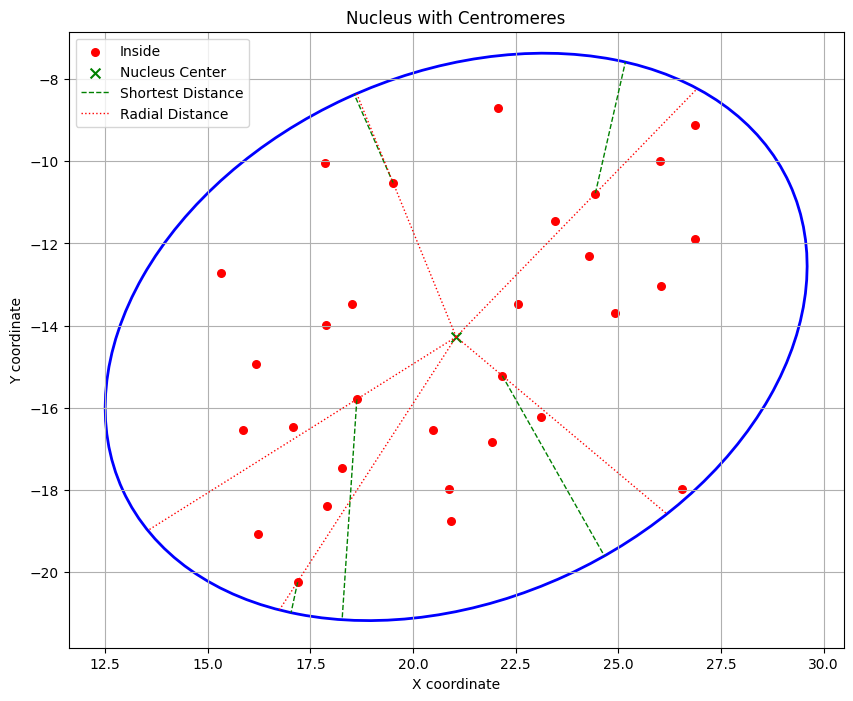

In [87]:
# Plot the nucleus and centromeres
plt.figure(figsize=(10, 8))

# Create ellipse for nucleus
ellipse = Ellipse((n_X, n_Y), n_DiameterMax, n_DiameterMin, 
                  angle=n_RotAngle, 
                  fill=False, edgecolor='blue', linewidth=2)
ax = plt.gca()
ax.add_patch(ellipse)

# Filter points inside and outside the ellipse
inside_points = centromeres[centromeres['Inside_Ellipse']]
outside_points = centromeres[~centromeres['Inside_Ellipse']]

# Plot centromeres
plt.scatter(inside_points['X'], inside_points['Y'], color='red', s=30, label='Inside')
if not outside_points.empty:
    plt.scatter(outside_points['X'], outside_points['Y'], color='orange', s=30, label='Outside')
plt.scatter([n_X], [n_Y], color='green', s=50, marker='x', label='Nucleus Center')

# Plot shortest distance lines for a few random points
np.random.seed(33)  # For reproducibility
if len(inside_points) > 0:
    sample_indices = np.random.choice(inside_points.index, min(5, len(inside_points)), replace=False)
    
    for idx in sample_indices:
        centromere = centromeres.loc[idx]
        x, y = centromere['X'], centromere['Y']
        
        # Find the closest point on ellipse
        angle_rad = np.deg2rad(n_RotAngle)
        x_r, y_r = transform_point(x, y, n_X, n_Y, angle_rad)
        
        def distance_function(t):
            ellipse_x = n_RadiusMax * np.cos(t)
            ellipse_y = n_RadiusMin * np.sin(t)
            return (x_r - ellipse_x)**2 + (y_r - ellipse_y)**2
        
        initial_t = np.arctan2(y_r / n_RadiusMin, x_r / n_RadiusMax) if (x_r != 0 or y_r != 0) else 0
        result = minimize(distance_function, initial_t, method='BFGS')
        t_min = result.x[0]
        
        closest_x = n_RadiusMax * np.cos(t_min)
        closest_y = n_RadiusMin * np.sin(t_min)
        
        ellipse_point_x, ellipse_point_y = inverse_transform(closest_x, closest_y, n_X, n_Y, angle_rad)
        
        plt.plot([x, ellipse_point_x], [y, ellipse_point_y], 'g--', linewidth=1, label='Shortest Distance' if idx == sample_indices[0] else '')
        
        # Plot radial distance line
        theta = np.arctan2(y_r, x_r) if (x_r != 0 or y_r != 0) else 0
        r = (n_RadiusMax * n_RadiusMin) / np.sqrt((n_RadiusMin * np.cos(theta))**2 + (n_RadiusMax * np.sin(theta))**2)
        edge_x_r = r * np.cos(theta)
        edge_y_r = r * np.sin(theta)
        
        edge_x, edge_y = inverse_transform(edge_x_r, edge_y_r, n_X, n_Y, angle_rad)
        
        plt.plot([n_X, edge_x], [n_Y, edge_y], 'r:', linewidth=1, label='Radial Distance' if idx == sample_indices[0] else '')

# Set plot properties
plt.axis('equal')
plt.grid(True)
plt.title('Nucleus with Centromeres')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best')

plt.show()

## Statistical Analysis

Generate statistical summaries of the distance measurements for all centromeres.

In [88]:
# Show statistical summary of distances
print("Distance Statistics:")
stats_df = centromeres[['Distance_to_Center', 'Radial_Distance_to_Edge', 
                        'Shortest_Distance_to_Edge', 'Distance_Ratio']].describe()
display(stats_df)

Distance Statistics:


,Distance_to_Center,Radial_Distance_to_Edge,Shortest_Distance_to_Edge,Distance_Ratio
count,30.000000,30.000000,30.000000,30.000000
mean,4.534378,3.344356,3.131305,0.577174
std,1.652396,1.684460,1.504000,0.206033
min,1.464677,0.241510,0.234167,0.190119
25%,3.314002,2.111391,2.031436,0.428177
50%,4.511438,3.613708,3.350004,0.575361
75%,5.666041,4.673462,4.291184,0.746338
max,7.767036,7.226820,6.250668,0.964842


## Visualize Distance Distributions

Create histograms to visualize the distribution of distances.

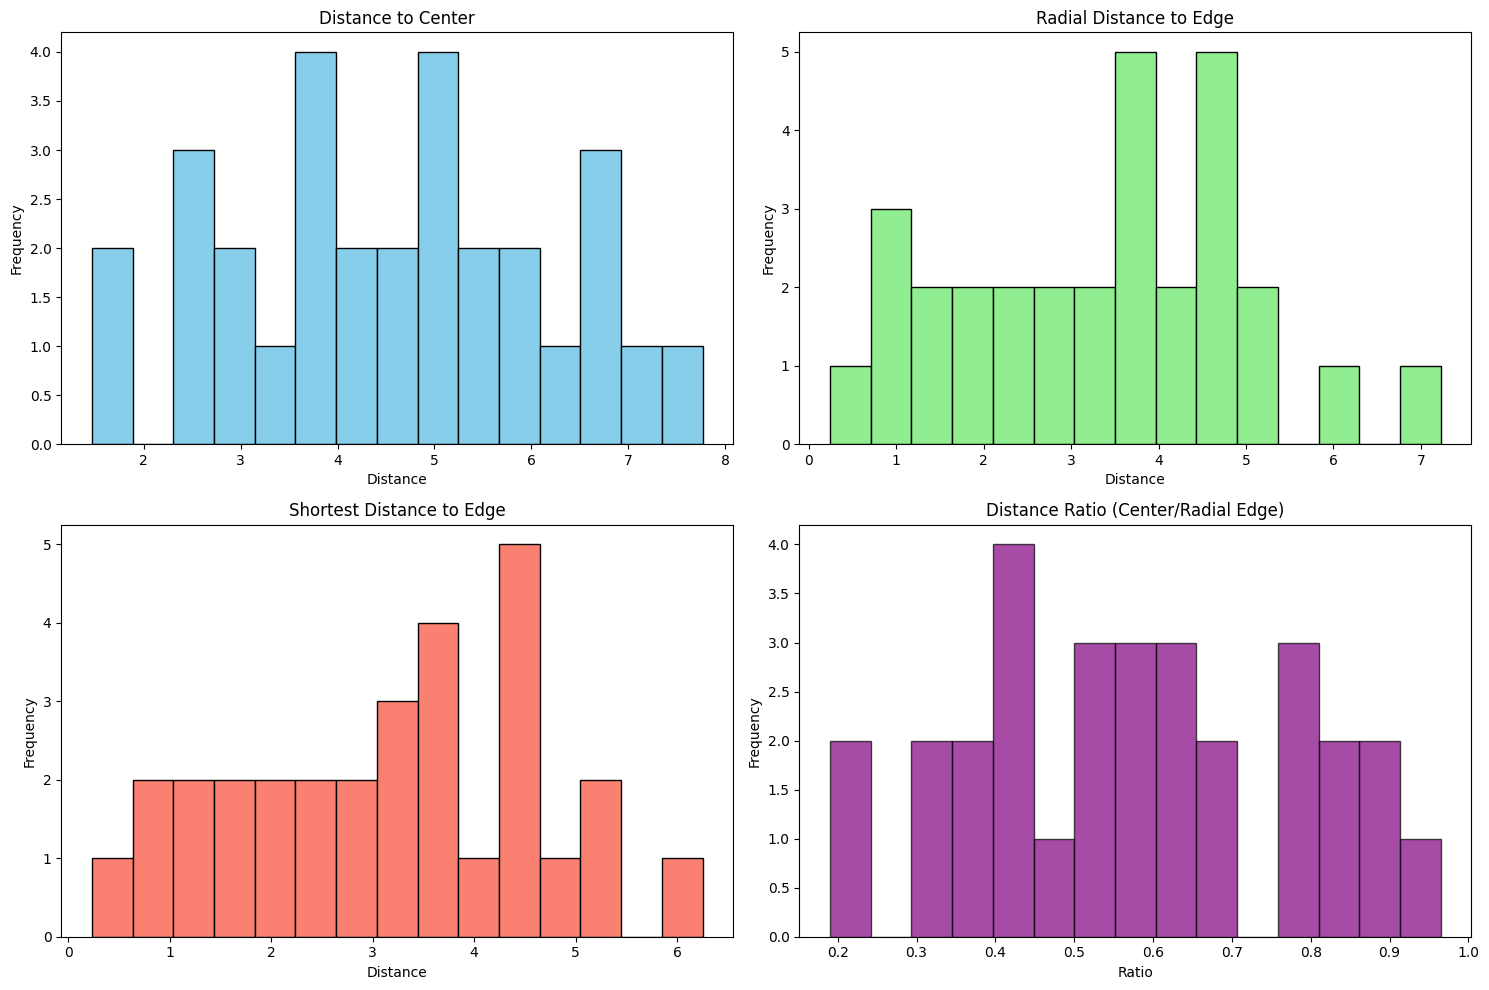

In [89]:
# Create histograms for distance distributions
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(centromeres['Distance_to_Center'], bins=15, color='skyblue', edgecolor='black')
plt.title('Distance to Center')
plt.xlabel('Distance')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(centromeres['Radial_Distance_to_Edge'].dropna(), bins=15, color='lightgreen', edgecolor='black')
plt.title('Radial Distance to Edge')
plt.xlabel('Distance')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(centromeres[centromeres['Inside_Ellipse']]['Shortest_Distance_to_Edge'], 
         bins=15, color='salmon', edgecolor='black')
plt.title('Shortest Distance to Edge')
plt.xlabel('Distance')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(centromeres['Distance_Ratio'].dropna(), bins=15, color='purple', edgecolor='black', alpha=0.7)
plt.title('Distance Ratio (Center/Radial Edge)')
plt.xlabel('Ratio')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Save Results

Export the analysis results to a CSV file.

In [90]:
# Prepare final dataframe with all the information
result_df = pd.concat([centromeres, data.iloc[[-1]]], ignore_index=False)

# Save to CSV
output_file = 'result.csv'
result_df.to_csv(output_file, index=False)

print(f"Results saved to {output_file}")

Results saved to result.csv


## Summary of Distance Analysis

This section provides a concise summary of the centromere positions relative to the nucleus periphery, including how many are near the edge.

In [91]:
# Generate summary statistics and insights
inside_data = centromeres[centromeres['Inside_Ellipse']].copy()

# Calculate percentages of centromeres at different distances from periphery
if len(inside_data) > 0:
    bins = [0, 5, 10, 15, float('inf')]
    labels = ['<5 pixels', '5-10 pixels', '10-15 pixels', '>15 pixels']
    inside_data['Distance_Category'] = pd.cut(inside_data['Shortest_Distance_to_Edge'], bins=bins, labels=labels)
    category_counts = inside_data['Distance_Category'].value_counts().sort_index()
    category_percentages = (category_counts / len(inside_data)) * 100

    # Display the summary
    print("\nSummary of Centromere Positions Relative to Nucleus Periphery:")
    for label, count, percentage in zip(labels, category_counts, category_percentages):
        print(f"{label}: {count} centromeres ({percentage:.2f}%)")

    # Additional insights
    mean_shortest_distance = inside_data['Shortest_Distance_to_Edge'].mean()
    median_shortest_distance = inside_data['Shortest_Distance_to_Edge'].median()
    print(f"\nMean shortest distance to edge: {mean_shortest_distance:.2f} pixels")
    print(f"Median shortest distance to edge: {median_shortest_distance:.2f} pixels")

    mean_ratio = inside_data['Distance_Ratio'].mean()
    print(f"Mean distance ratio: {mean_ratio:.2f} (where 0 is center and 1 is periphery)")
else:
    print("No centromeres are inside the nucleus.")


Summary of Centromere Positions Relative to Nucleus Periphery:
<5 pixels: 27 centromeres (90.00%)
5-10 pixels: 3 centromeres (10.00%)
10-15 pixels: 0 centromeres (0.00%)
>15 pixels: 0 centromeres (0.00%)

Mean shortest distance to edge: 3.13 pixels
Median shortest distance to edge: 3.35 pixels
Mean distance ratio: 0.58 (where 0 is center and 1 is periphery)
